In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

---

<b>Read in the data</b>

In [2]:
train = pd.read_csv("CSI4810_projectVehicleData/train.csv")
target = train.pop("loan_default")
test = pd.read_csv("CSI4810_projectVehicleData/test.csv")
train.columns=train.columns.str.replace('.','_').str.lower()
test.columns=test.columns.str.replace('.','_').str.lower()

print(train.info())
print(train.describe())

C:\Users\willo_jlqcl0r\AppData\Local\Temp\ipykernel_20524\3524391563.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("CSI4810_projectVehicleData/train.csv")


(233154, 40)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 40 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   uniqueid                             233154 non-null  int64  
 1   disbursed_amount                     233154 non-null  int64  
 2   asset_cost                           233154 non-null  int64  
 3   ltv                                  233154 non-null  float64
 4   branch_id                            233154 non-null  object 
 5   supplier_id                          233154 non-null  int64  
 6   manufacturer_id                      233154 non-null  int64  
 7   current_pincode_id                   233154 non-null  int64  
 8   date_of_birth                        233154 non-null  object 
 9   employment_type                      225493 non-null  object 
 10  disbursaldate                        233154 non-null  object 
 11  

In [21]:
counts = target.value_counts()
print(f"Percent of entries that are NOT likely to default \t{counts[0]/counts.sum() * 100:.2f}%")
print(f"Percent of entries that are likely to default\t\t{counts[1]/counts.sum() * 100:.2f}%")

Percent of entries that are NOT likely to default 	78.29%
Percent of entries that are likely to default		21.71%


---

#### <b>Investigation</b>

In [5]:
train[['branch_id']]
train['branch_id'].unique()

array(['67', '-', '78', '34', '130', '74', '11', '5', '20', '63', '48',
       '79', '3', '42', '142', '36', '16', '146', '147', '65', '9', '1',
       '152', '29', '10', '70', '19', '7', '85', '61', '17', '8', '153',
       '18', '162', '68', '72', 10, 36, 7, 67, 61, 146, 16, 48, 11, 3, 64,
       85, 63, 18, 2, 160, 9, 251, 65, 162, 70, 152, 42, 8, 19, 17, 1, 20,
       68, 103, 34, 5, 104, 120, 72, 78, 130, 142, 147, 79, 136, 77, 13,
       153, 74, 29, 138, 135, 73, 248, 15, 165, 62, 76, 105, 249, 250,
       255, 254, 82, 158, 159, 117, 202, 259, 207, 35, 69, 97, 43, 257,
       258, 260, 111, 66, 261, 101, 14, 121, 217, 84, 100], dtype=object)

---

<b>Converting all date columns to uniform format and extracting year when necessary</b>

In [30]:
def convertDates(dates):
    dates1 = pd.to_datetime(dates[dates.str.contains("-")], dayfirst=True, format="%d-%m-%y")
    dates2 = pd.to_datetime(dates[dates.str.contains("/")], format="%m/%d/%Y")
    return pd.concat([dates1, dates2]).sort_index()

train["disbursaldate"] = convertDates(train["disbursaldate"]).dt.date
train['disbursaldate_days'] = (pd.to_datetime('01-01-2019') - pd.to_datetime(train['disbursaldate'])).dt.days

train["birth_year"] = train["date_of_birth"].str.split(r'[-/]', expand=True, regex=True).iloc[:,2].astype(int).apply(lambda year : (2000 + year if year == 00 else 1900 + year) if year < 100 else year)

---

<b>Convert mixed data type all to integer</b><br>
As we can see there is some string and some integer values. We can also see some hidden nulls where branch id = '-'. I will convert these unknown branches to their own encoding value of 0


In [31]:
print(train["branch_id"].unique(),"\n")
train["branch_id"] = train["branch_id"].astype(str).str.replace('-','67').astype(int)
print(train["branch_id"].unique())

['67' '-' '78' '34' '130' '74' '11' '5' '20' '63' '48' '79' '3' '42' '142'
 '36' '16' '146' '147' '65' '9' '1' '152' '29' '10' '70' '19' '7' '85'
 '61' '17' '8' '153' '18' '162' '68' '72' 10 36 7 67 61 146 16 48 11 3 64
 85 63 18 2 160 9 251 65 162 70 152 42 8 19 17 1 20 68 103 34 5 104 120 72
 78 130 142 147 79 136 77 13 153 74 29 138 135 73 248 15 165 62 76 105 249
 250 255 254 82 158 159 117 202 259 207 35 69 97 43 257 258 260 111 66 261
 101 14 121 217 84 100] 

[ 67   0  78  34 130  74  11   5  20  63  48  79   3  42 142  36  16 146
 147  65   9   1 152  29  10  70  19   7  85  61  17   8 153  18 162  68
  72  64   2 160 251 103 104 120 136  77  13 138 135  73 248  15 165  62
  76 105 249 250 255 254  82 158 159 117 202 259 207  35  69  97  43 257
 258 260 111  66 261 101  14 121 217  84 100]


---

<b>Filling in null values</b><br>
The only column that has missing values is the employment_type column. For now, we will treat the missing values as their own category of unknown/unemployed. The reason I am starting with this approach is that there seems to be some relation between those born after 1995 and having a null entry in employment_type. After I select a model for prediction, I will revisit these null values to verfiy that this is the correct null handling. 

---

<b>Encoding</b><br>


In [32]:
def categorizeCreditRisk(data):
    patterns = {
        r".-very low.*":1,
        r".-low.*":2,
        r".-medium.*":3,
        r".-high.*":4,
        r".-very high.*":5,
        r"no.*":0
    } # acount for cosigner?
    for pattern, replacement in patterns.items():
        data['perform_cns_score_description'] = data['perform_cns_score_description'].str.replace(pattern,
            str(replacement), regex=True,case=False)
    return data['perform_cns_score_description']

def convertyXyrsXmonColumns(column):
    df = pd.DataFrame()
    df[['avg_acct_age_years','avg_acct_age_months']] = column.str.extract(r'(\d+)yrs (\d+)mon')
    return df["avg_acct_age_years"].astype(int) * 365 + df['avg_acct_age_months'].astype(int) * 30

print(train["perform_cns_score_description"].value_counts())
train["perform_cns_score_description"] = categorizeCreditRisk(train).astype(int)

train['avg_acct_age_days'] = convertyXyrsXmonColumns(train['average_acct_age'])

train['credit_history_length_days'] = convertyXyrsXmonColumns(train['credit_history_length'])

train['employment_type'] = LabelEncoder().fit_transform(train['employment_type'])

---

<b>Drop columns</b><br>
The mobileno_avl_flag column has only 1 distinct value so we will drop it

In [33]:
print(train["mobileno_avl_flag"].unique())
train = train.drop(["mobileno_avl_flag",'credit_history_length','average_acct_age','disbursaldate','date_of_birth'],axis=1)

[1]


---

<b>Outliers</b><br>
dropping outliers

In [ ]:
# TODO 

---

#### <b>Data Visualizations</b><br>


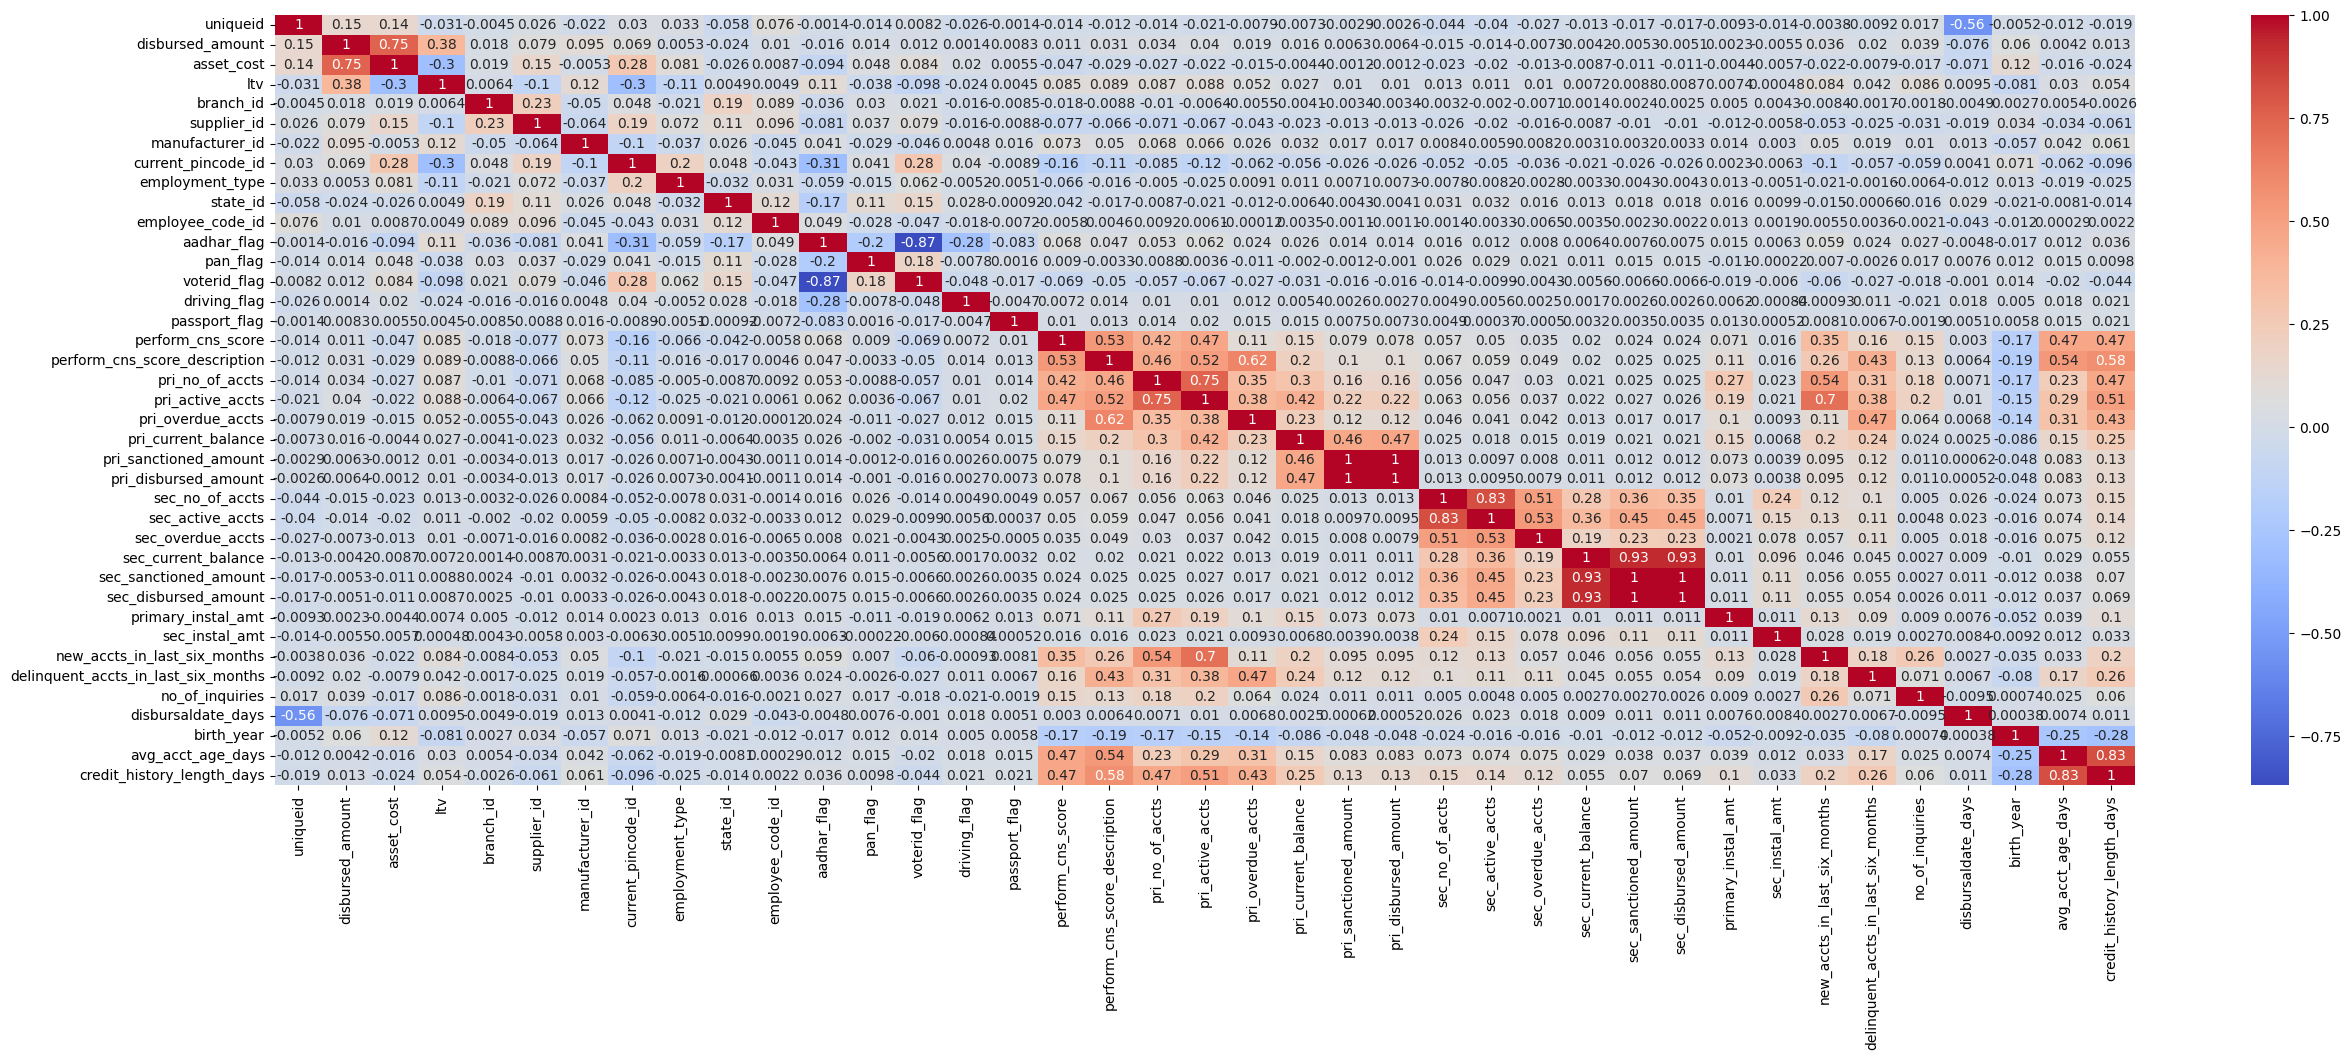

In [34]:
scaler = StandardScaler()
normalizedTrain = pd.DataFrame(scaler.fit_transform(train) , columns=train.columns)
c = normalizedTrain.corr()

plt.figure(figsize=(30, 10))
sns.heatmap(c, annot=True, cmap='coolwarm')
plt.show()

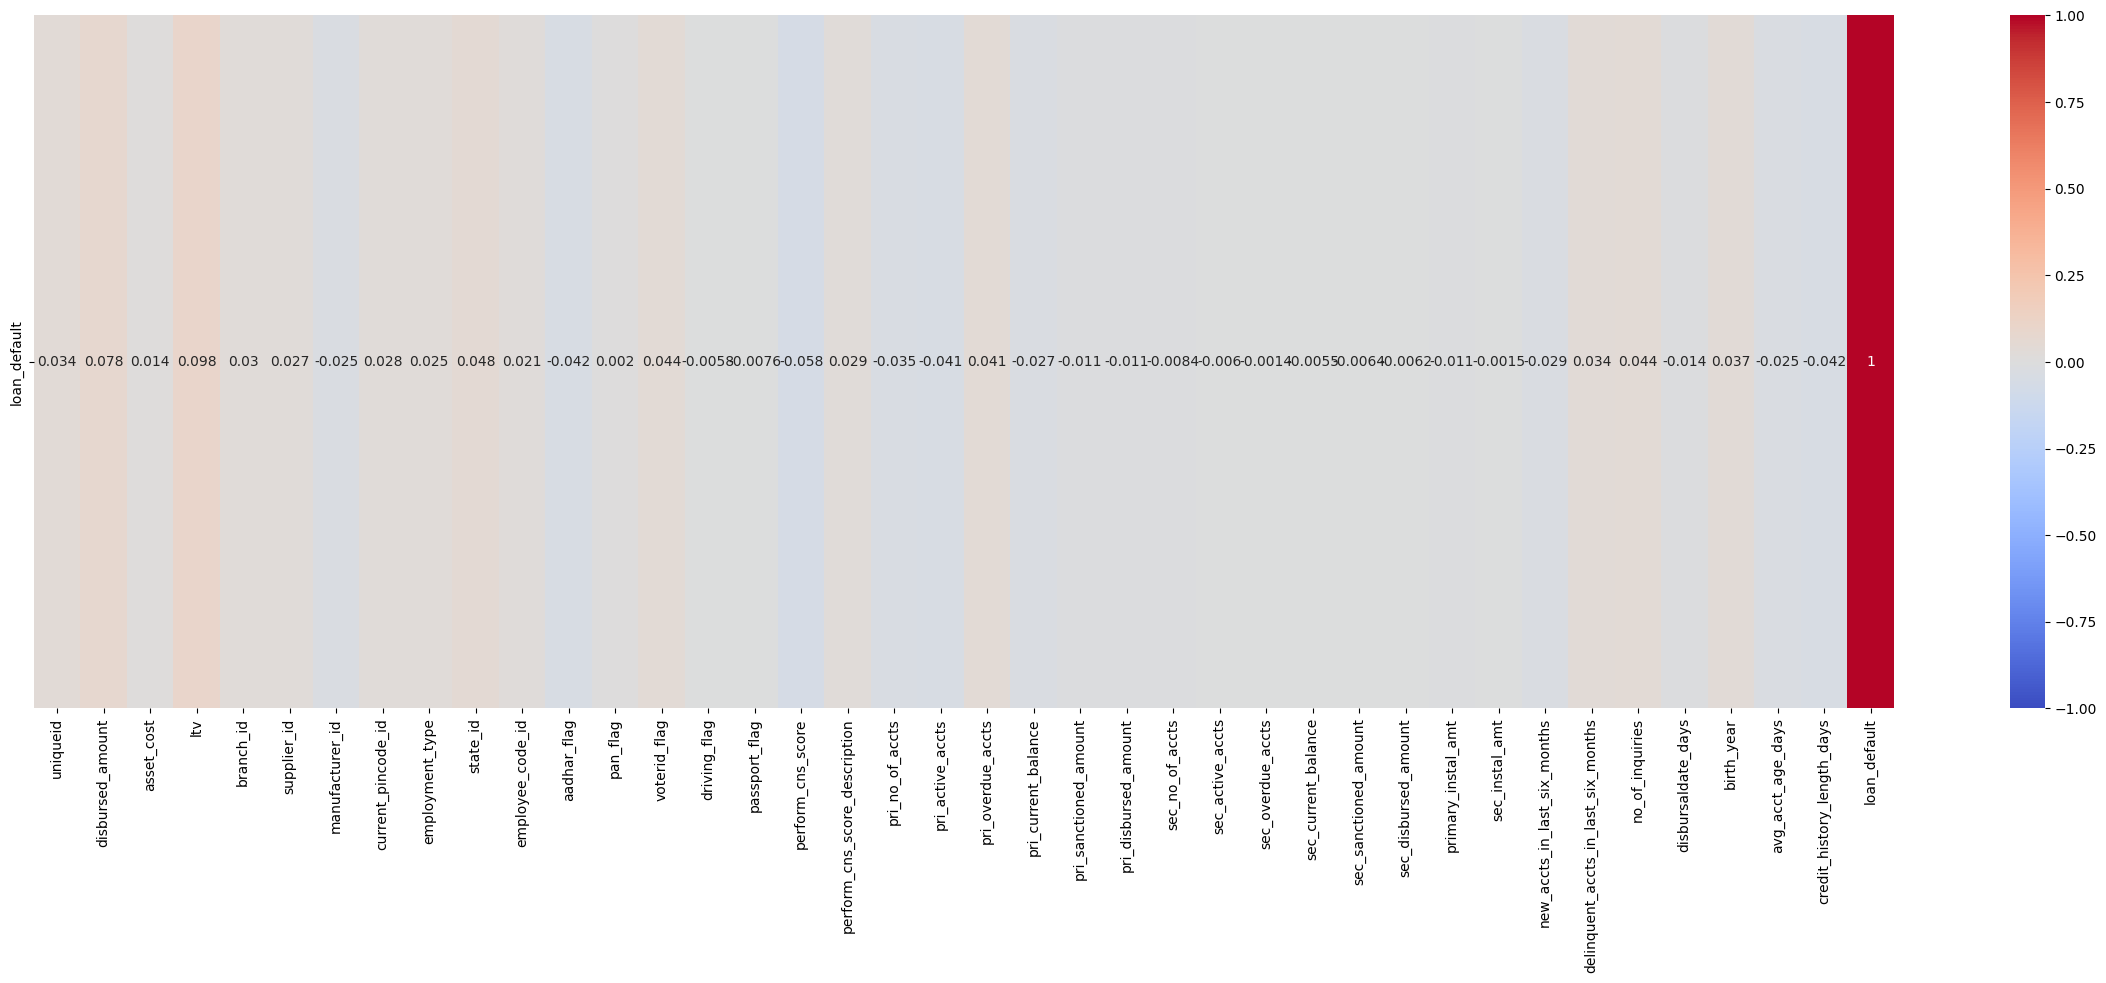

In [35]:
c = pd.concat([normalizedTrain, target], axis=1).corr()
plt.figure(figsize=(30, 9))
sns.heatmap(c.loc[['loan_default']], annot=True, cmap='coolwarm',vmin=-1,vmax=1)
plt.show()

In [36]:

def visualizeHistograms(data):
    plt.figure(figsize=(40 ,230))
    for i in range(39):
        plt.subplot(10, 4, i + 1) 
        plt.subplots_adjust(bottom=.5) 
        plt.title(f"{data.columns[i]}",fontsize=20)
        if not pd.api.types.is_numeric_dtype(data.iloc[:, i]):
            data[data.columns[i]].value_counts().plot(kind='bar')
        else:
            plt.hist(train.iloc[:, i], bins=30)
        plt.xticks(fontsize=28,rotation=25)
        plt.yticks(fontsize=18)
    plt.show()

visualizeHistograms(train)

---

<b>Box Plots</b><br>


In [37]:
# train.boxplot()
# plt.title('Box Plot of Your Data')
# plt.ylabel('Values')
# plt.show()

---

<b>Create new features</b><br>

age - we are adding an age column aggregated from the birth_year column to calculate approximately how old the customers are. This data was collected in 2018, so we will calculate their ages from the year 2019.


In [39]:
train['age'] = 2019 - train["birth_year"]

train['pri_percent_credit_used'] = (train['pri_disbursed_amount'] / train['pri_sanctioned_amount']) * 100
train['sec_percent_credit_used'] = (train['sec_disbursed_amount'] / train['sec_sanctioned_amount']) * 100

In [40]:
train = train.drop(['birth_year','sec_disbursed_amount','pri_disbursed_amount'],axis=1)

In [31]:
# normalizedTrain = pd.DataFrame(scaler.fit_transform(train))
# c = normalizedTrain.corr()

# plt.figure(figsize=(30, 10))
# sns.heatmap(c, annot=True, cmap='coolwarm')
# plt.show()
# print(np.max(train['pri_percent_credit_used']))